In [1]:
%pylab inline 
import geopandas as gpd 
import rasterio as rio 
import rasterio.mask as mask
import rasterio.features
import rasterio.plot as riop 
import shapely

import os
from gis_functions import clip_raster_to_geometry, clip_shp_to_geometry
from sinkhole_functions import calc_karst_fraction

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_3536751/117532100.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [34]:
datadir = '/home/mcoving/github/sinkhole_analysis/PR/'

basedir = '/home/mcoving/Dropbox/sync/projects/Dolines/Puerto-Rico/'

PR_huc12 = gpd.read_file(basedir+'NHDPLUS_H_2101_HU4_GDB.gdb', layer='WBDHU12')

In [4]:
PR_huc12

,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,referencegnis_ids,areaacres,areasqkm,states,huc12,name,hutype,humod,tohuc,noncontributingareaacres,noncontributingareasqkm,shape_Length,shape_Area,geometry
0,{E52E4A37-D513-4630-A2F1-64E8302B6070},{5F3A5C33-7C94-4A21-8000-980A11DD6B86},None,None,None,2019-12-05 10:33:54+00:00,None,4773.24,19.32,PR,210100080202,Southern Culebra,None,NM,210100080203,0.0,0.000000,0.598650,0.001651,"MULTIPOLYGON (((-65.34234 18.34678, -65.34189 ..."
1,{8F2F04C9-45DE-4B42-B54D-63DA4481AD92},{06E756BD-CFEA-454A-BC85-5E3AC5F20D43},None,None,None,2019-12-05 10:33:54+00:00,None,80141.40,324.32,PR,210100070102,Anclaje Isabella-Caribbean Sea,None,NM,OCEAN,NaN,NaN,0.995599,0.027685,"MULTIPOLYGON (((-67.88774 18.16654, -67.88689 ..."
2,{EF15641F-C68E-4DF6-A40B-F56C53B820AB},{5F3A5C33-7C94-4A21-8000-980A11DD6B86},None,None,None,2016-07-25 23:27:01+00:00,None,424.97,1.72,PR,210100040304,Rio Matilde at mouth,None,NM,210100040600,0.0,0.000000,0.069456,0.000147,"MULTIPOLYGON (((-66.63754 17.98177, -66.63760 ..."
3,{64C2EB31-5CE0-4B84-8CC4-017D258C3198},None,None,None,None,2013-01-18 07:08:54+00:00,None,14250.33,57.67,PR,210100020106,Rio Cibuco near mouth,None,"KA,NC",210100020107,2025.0,8.194892,0.675921,0.004930,"MULTIPOLYGON (((-66.36469 18.44251, -66.36382 ..."
4,{40B6A464-3C87-4E77-A252-FD36A5F68A70},None,None,None,None,2013-01-18 07:08:54+00:00,None,16134.52,65.29,PR,210100020208,Rio Toro Negro,None,"IT,PD",210100020210,0.0,0.000000,0.570811,0.005578,"MULTIPOLYGON (((-66.45012 18.28603, -66.45019 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,{D4D7FE82-5D3C-4BC2-8C74-9AF7CBCB42AE},None,None,None,None,2013-01-18 07:08:54+00:00,None,8949.83,36.22,PR,210100050402,Rio Cayaguas,None,NM,210100050409,0.0,0.000000,0.330635,0.003092,"MULTIPOLYGON (((-65.95453 18.16629, -65.95418 ..."
223,{A0391558-503A-4333-81A6-7E3F3EFA790A},None,None,None,None,2013-01-18 07:08:54+00:00,None,19006.25,76.92,PR,210100050403,Rio Turabo,None,NM,210100050409,0.0,0.000000,0.465387,0.006568,"MULTIPOLYGON (((-66.01960 18.14555, -66.01984 ..."
224,{C879F2FB-6F60-4502-A79F-328E5507DB91},None,None,None,None,2013-01-18 07:08:54+00:00,None,5005.87,20.26,PR,210100050405,Rio Bairoa,None,NM,210100050409,0.0,0.000000,0.315542,0.001731,"MULTIPOLYGON (((-66.01644 18.25691, -66.01655 ..."
225,{27747635-EC32-4048-ACAE-05E0CD0A4197},None,None,None,None,2013-01-18 07:08:54+00:00,None,8410.29,34.04,PR,210100050410,Quebrada Grande,None,NM,210100050414,0.0,0.000000,0.280557,0.002909,"MULTIPOLYGON (((-65.96990 18.34061, -65.96964 ..."


In [6]:
bbox = shapely.geometry.box(-66.660, 18.331,  -66.600, 18.357)

In [9]:
want_hucs = PR_huc12[PR_huc12.intersects(bbox)]

In [48]:
#this_huc = want_hucs.iloc[0]
this_huc = want_hucs[want_hucs.huc12 == '210100020301']


In [38]:
clipname='HUC-' + str(this_huc.huc12) + '-'
clipname

'HUC-29    210100020301\nName: huc12, dtype: object-'

In [42]:
os.chdir(datadir)
rasterdir = os.path.join(basedir,'HRNHDPlusRasters2101/')
rasterfile = 'elev_cm.tif'
img_elev = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=this_huc,
                              clipname='HUC-' + this_huc.huc12.array[0] + '-')


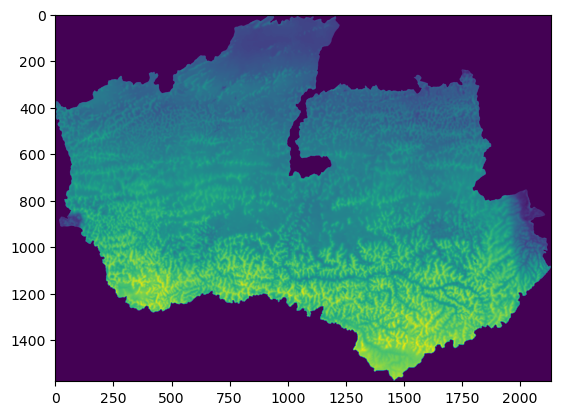

<AxesSubplot: >

In [43]:
riop.show(img_elev)

In [27]:
type(want_hucs[want_hucs.huc12 == '210100020301'])

geopandas.geodataframe.GeoDataFrame

In [29]:
for huc in want_hucs:
    print((huc))

tnmid
metasourceid
sourcedatadesc
sourceoriginator
sourcefeatureid
loaddate
referencegnis_ids
areaacres
areasqkm
states
huc12
name
hutype
humod
tohuc
noncontributingareaacres
noncontributingareasqkm
shape_Length
shape_Area
geometry


In [30]:
want_hucs

,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,referencegnis_ids,areaacres,areasqkm,states,huc12,name,hutype,humod,tohuc,noncontributingareaacres,noncontributingareasqkm,shape_Length,shape_Area,geometry
29,{FE03F989-12E4-41A6-941B-298AF2758DC7},None,None,None,None,2013-01-18 07:08:54+00:00,None,49107.46,198.73,PR,210100020301,Non-contributing area-Name not assigned,None,"KA,NC",CLOSED BASIN,49105.87467,198.7246,0.957397,0.016989,"MULTIPOLYGON (((-66.56338 18.43619, -66.56346 ..."
94,{7856F4E3-8D77-4B56-9DA3-9715B102FFD1},None,None,None,None,2013-01-18 07:08:54+00:00,None,12725.48,51.50,PR,210100020410,Rio Limon,None,KA,210100020411,0.00000,0.0000,0.359609,0.004400,"MULTIPOLYGON (((-66.61011 18.32935, -66.61028 ..."
95,{6440D1E7-C393-4ABA-90D2-A77C88370891},{5F3A5C33-7C94-4A21-8000-980A11DD6B86},None,None,None,2016-07-25 23:26:57+00:00,None,12862.87,52.05,PR,210100020414,Rio Grande de Arecibo at mouth,None,KA,210100020600,0.00000,0.0000,0.617576,0.004451,"MULTIPOLYGON (((-66.71080 18.47259, -66.71061 ..."
173,{ACDF75F6-010B-4C1E-99BA-3AC761B13D4A},None,None,None,None,2013-01-18 07:08:54+00:00,None,4466.32,18.07,PR,210100020411,Rio Caonillas,None,"IT,PD",210100020412,0.00000,0.0000,0.201805,0.001545,"MULTIPOLYGON (((-66.65755 18.33533, -66.65744 ..."
